## **Setup**

In [1]:
import os
import random
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys

from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Input
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import roc_auc_score, roc_curve, auc
from matplotlib.colors import LinearSegmentedColormap
from termcolor import colored

from tensorflow.keras.applications import ResNet50, VGG19, InceptionResNetV2
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as inception_resnet_v2_preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Set seed for reproducibility of results
seed_value = 0
os.environ['PYTHONHASHSEED']=str(seed_value)
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

tf.compat.v1.reset_default_graph()

random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.compat.v1.set_random_seed(seed_value)

# Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

tf.__version__

'2.3.0'

In [2]:
from google.colab import drive
mount_path = '/content/gdrive/'
drive.mount(mount_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
4/4AGBfNN7J2XJsl4P7EO-Sy8VCPd-d4tSoDD9cyrek-Bjl-xapdDpkXE
Mounted at /content/gdrive/


In [3]:
# Set and test path to competition data files
competition_path = 'My Drive/Final Project ITC/MAFAT Challenge/Data'
try:
  if competition_path == 'INSERT HERE':
    print('Please enter path to competition data files:')
    competition_path = input()
  file_path = 'MAFAT RADAR Challenge - Training Set V1.csv'
  with open(f'{mount_path}/{competition_path}/{file_path}') as f:
    f.readlines()
  print(colored('Everything is setup correctly', color='green'))
except:
  print(colored('Please mount drive and set competition_path correctly',
                color='red'))

Everything is setup correctly


## **Functions**

All functions will be used in the "Training the Model" section.

In [4]:
files_path = mount_path + "/" + "My Drive/Final Project ITC/MAFAT Challenge/Our notebooks/Inbar"

sys.path.append(files_path)

In [5]:
from loading_functions import load_data, load_pkl_data, load_csv_metadata
from spectogram_plots import plot_shited_spectrogram, plot_recenter_midline_spectrogram, spectrogram_cmap
from model_roc_function import stats
from data_augmentation import  recenter_midline, shift_spectrogram
from data_preprocessing_funcs import data_preprocess
from plot_learning_curve import plot_loss_and_accuracy_over_epoches
from data_augmentation import recenter_midline, shift_spectrogram

### **Splitting the Training set**

The functions below split the training set into Train and Validation sets.

* Validation Set.   
The validation set is constructed from segments from geolocation_ids 1 and 4.   
These geolocations' target_type distributions are balanced.
To create a fair representation of the test set   
(one segment form each track) every sixth segment was taken to the validation set.   
The reason is that approximately 75% of the tracks have less than 6 segments,   
it guarantees that most of the segments in the validation set are not from the same track.   
   
* Adding "human" segments to the training set.   
The training set is imbalanced.   
One can address this issue by taking segements of humans from the "Auxiliary Experiment Set".   
The first 3 segments from each track are taken into the training set (or less if the track is shorter than 3 segments).

In [11]:
# Function for splitting the data to training and validation
# and function for selecting samples of segments from the Auxiliary dataset
def split_train_val(data):
  """
  Split the data to train and validation set.
  The validation set is built from training set segments of 
  geolocation_id 1 and 4. 
  Use the function only after the training set is complete and preprocessed. 

  Arguments:
    data -- {ndarray} -- the data set to split

  Returns:
    iq_sweep_burst ndarray matrices
    target_type vector 
    for training and validation sets
  """
  idx = ((data['geolocation_id'] == 4) | (data['geolocation_id'] == 1))\
   & (data['segment_id'] % 6 == 0)
  training_x = data['iq_sweep_burst'][np.logical_not(idx)]
  training_y = data['target_type'][np.logical_not(idx)]
  validation_x = data['iq_sweep_burst'][idx]
  validation_y = data['target_type'][idx]
  return training_x, training_y, validation_x, validation_y

def aux_split(data):
  """
  Selects segments from the auxilary set for training set.
  Takes the first 3 segments (or less) from each track.

  Arguments:
    data {dataframe} -- the auxilary data

  Returns:
    The auxilary data for the training
  """
  idx = np.bool_(np.zeros(len(data['track_id'])))
  for track in np.unique(data['track_id']):
    idx |= data['segment_id']==(data['segment_id'][data['track_id'] == track][:3])

  print(idx)
  
  for key in data:
    data[key] = data[key][idx]
  return data

## **Model**

### **CNN Model** - transfer learning


In [7]:
# Building the model
def create_model(model_tl, init, input_shape= (126, 32, 3)):
  """
  Transfer learning Resnet model. trained on imagenet
  The input shape must be RGB, hense we must duplicate the channel 3 times

  Arguments:
    input_shape -- the shape of our input
    init -- the weight initialization

  Returns:
    CNN model - with resnet inside  
  """
  tl_model = Sequential(name="transfer_learning_model")
  tl_model.add(Input(shape=input_shape))

  transfer_learning_model = model_tl(include_top=False, weights="imagenet", pooling='avg')

  tl_model.add(Model(inputs=transfer_learning_model.input, outputs=transfer_learning_model.get_layer('block5_conv2').output))
  tl_model.add(Flatten())
  #tl_model.add(transfer_learning_model)

  # tl_model.add(Dense(128, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))
  # tl_model.add(Dropout(.2))

  # tl_model.add(Dense(32, kernel_regularizer = 'l2', activation='relu', kernel_initializer = init))
  # tl_model.add(Dropout(.2))

  tl_model.add(Dense(1, activation='sigmoid', kernel_initializer = init))

  # Say not to train first layer (ResNet) model. It is already trained
  tl_model.layers[0].trainable = False
  return tl_model

## **Training The Model**

#### loading the data and pre-processing

In [8]:
# Loading and preparing the data

# Loading Auxiliary Experiment set - can take a few minutes
experiment_auxiliary = 'MAFAT RADAR Challenge - Auxiliary Experiment Set V2'
experiment_auxiliary_df = load_data(experiment_auxiliary)

In [12]:
# Taking sample from the Auxiliary Experiment set
train_aux = aux_split(experiment_auxiliary_df)

[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  T

In [10]:
train_aux

{'date_index': array([3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
        3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3,
        3]), 'doppler_burst': array([[ 16,  16,  16, ...,  11,  13,  12],
        [ 15,  15,  16, ...,  17,  17,  15],
        [ 22,  22,  20, ...,  21,  16,  18],
        ...,
        [109, 102,  98, ..., 110,  90,  99],
        [ 15,  15,  15, 

In [ ]:
# The function append_dict is for concatenating the training set 
# with the Auxiliary data set segments

def append_dict(dict1, dict2):
  for key in dict1:
    dict1[key] = np.concatenate([dict1[key], dict2[key]], axis=0)
  return dict1

In [ ]:
# Training set
train_path = 'MAFAT RADAR Challenge - Training Set V1'
training_df = load_data(train_path)

# Adding segments from the experiment auxiliary set to the training set
train_df = append_dict(training_df, train_aux)

# Preprocessing and split the data to training and validation
train_df = data_preprocess(train_df.copy())
train_x, train_y, val_x, val_y = split_train_val(train_df)

val_y = val_y.astype(int)
train_y = train_y.astype(int)

#### check data augmnetation - present

In [ ]:
np.save('/content/cmap.npy', spectrogram_cmap)

In [ ]:
# plot_shited_spectrogram(train_x[0], shift=30)
# plot_recenter_midline_spectrogram(train_x[6])

#### contiune the data preparation

In [ ]:
#train_x = train_x.reshape(list(train_x.shape)+[1])

train_x = np.repeat(train_x[...,np.newaxis], 3, -1)

#val_x = val_x.reshape(list(val_x.shape)+[1])

val_x = np.repeat(val_x[...,np.newaxis], 3, -1)

In [ ]:
# Public test set - loading and preprocessing
test_path = 'MAFAT RADAR Challenge - Public Test Set V1'
test_df = load_data(test_path)
test_df = data_preprocess(test_df.copy())
test_x = test_df['iq_sweep_burst']
#test_x = test_x.reshape(list(test_x.shape)+[1])

test_x = np.repeat(test_x[...,np.newaxis], 3, -1)

In [ ]:
# Model configuration:
batch_size = 16
img_width, img_height = 126, 32
loss_function = BinaryCrossentropy()
no_epochs = 100
optimizer = Adam(learning_rate = 0.001)

init = tf.keras.initializers.GlorotNormal(seed = 0)

#input_shape = (img_width, img_height, 1) 

input_shape = (img_width, img_height, 3)  # must be 3 is RGB for using transfer learning

# callbacks
earlystop = EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)

#### ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(
                              #vertical_flip = True,
                              #horizontal_flip=True,
                              #width_shift_range = 0.9,
                              #height_shift_range=0.05,
                              #fill_mode='nearest',
                              #brightness_range = [0.7,1.1],
                              #preprocessing_function = recenter_midline
                            )


#Fitting the Image Generator defined above to the X train data set
datagen.fit(train_x)

#### plot examples from imagedatagenerator

In [ ]:
# for image in train_x[:2]:
#    plt.imshow(image[:, :, 0], cmap=color_map); plt.show()

In [ ]:
# #Fitting the Image Generator defined above to the X train data set
# train_generator.fit(train_x)

# for X_batch, y_batch in train_generator.flow(train_x, train_y, batch_size= 2):
#     for image in X_batch:
#       plt.imshow(image[:, :, 0], cmap=color_map); plt.show()
#     break

### Resnet50

In [ ]:
# # Creating and running the model
# resnet_model = create_model(ResNet50, init,input_shape)  
# resnet_model.compile(loss=loss_function, optimizer=optimizer, metrics=[AUC(), 'accuracy'])
# resnet_model.summary()

In [ ]:
# train_gen = datagen.flow(train_x, train_y, batch_size=batch_size)

# history_resnet50 = resnet_model.fit(train_gen,
#           steps_per_epoch=len(train_x) // batch_size,
#           epochs=no_epochs,
#           validation_data=(val_x, val_y),
#           validation_steps=len(val_x) // batch_size,
#           callbacks=earlystop)
          

### VGG19

In [ ]:
# Creating and running the model
vgg_19_model = create_model(VGG19, init, input_shape)  
vgg_19_model.compile(loss=loss_function, optimizer=optimizer, metrics=[AUC(), 'accuracy'])
vgg_19_model.summary()

Model: "transfer_learning_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_3 (Functional)    (None, None, None, 512)   15304768  
_________________________________________________________________
flatten_1 (Flatten)          (None, 7168)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 7169      
Total params: 15,311,937
Trainable params: 15,311,937
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train_gen = datagen.flow(train_x, train_y, batch_size=batch_size)

history_vgg19 = vgg_19_model.fit(train_gen,
          steps_per_epoch=len(train_x) // batch_size,
          epochs=no_epochs,
          validation_data=(val_x, val_y),
          validation_steps=len(val_x) // batch_size,
          callbacks=earlystop)
          

Epoch 1/100


TypeError: ignored

Inception resnet_v2 - 

problem - minimun input must be (75X75)

In [ ]:
# Creating and running the model
# model = create_model(InceptionResNetV2, input_shape)  
# model.compile(loss=loss_function, optimizer=optimizer, metrics=[AUC(), 'accuracy'])

# datagen = ImageDataGenerator(preprocessing_function=inception_resnet_v2_preprocess_input)
# train_gen = datagen.flow(train_x, train_y, batch_size=batch_size)

# history_inception_resv2 = model.fit(train_gen,
#           steps_per_epoch=len(train_x) // batch_size,
#           epochs=no_epochs,
#           validation_data=(val_x, val_y),
#           validation_steps=len(val_x) // batch_size,
#           callbacks=earlystop)
          

## **Results**

In [ ]:
# plot_loss_and_accuracy_over_epoches(history_resnet50)

In [ ]:
# Plot ROC curve and show ROC-AUC results of the training and validation sets. 
# pred = [resnet_model.predict(train_x), resnet_model.predict(val_x)]
# actual = [train_y, val_y]
# stats(pred, actual)

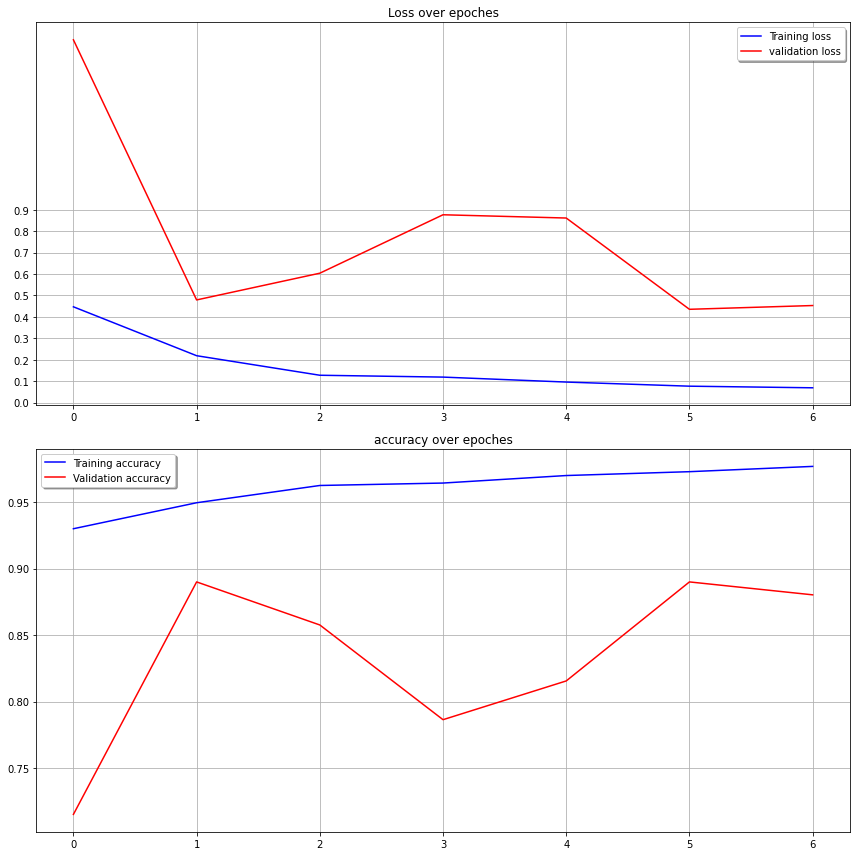

In [ ]:
plot_loss_and_accuracy_over_epoches(history_vgg19)

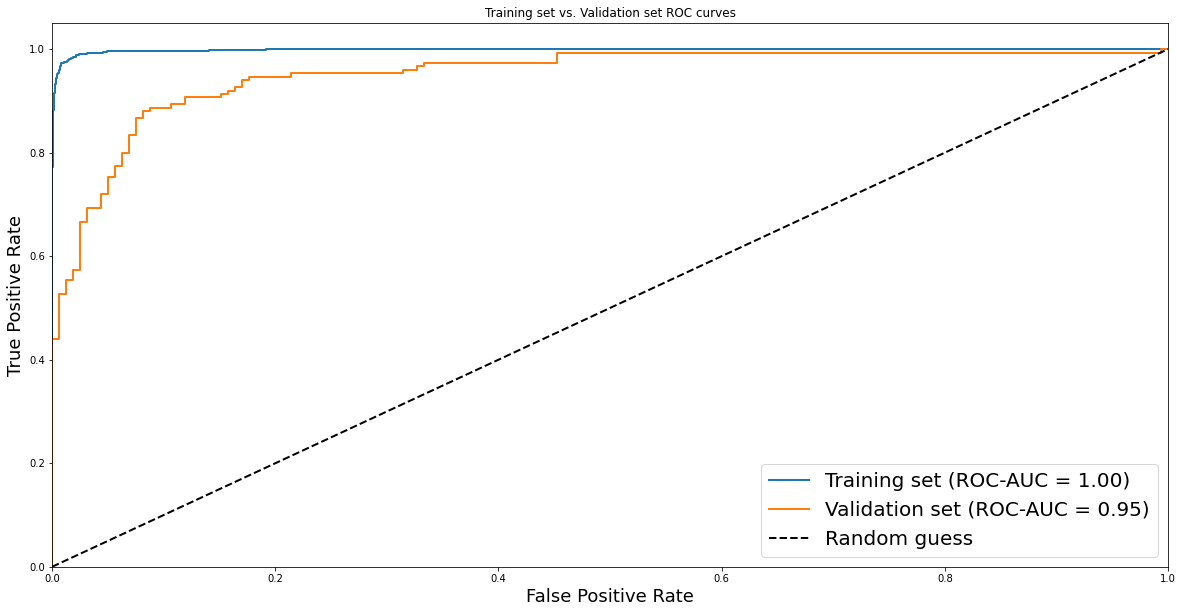

In [ ]:
# Plot ROC curve and show ROC-AUC results of the training and validation sets. 
pred = [vgg_19_model.predict(train_x), vgg_19_model.predict(val_x)]
actual = [train_y, val_y]
stats(pred, actual)

In [ ]:
# Creating DataFrame with the probability prediction for each segment
submission =  pd.DataFrame()
submission['segment_id'] = test_df['segment_id']
submission['prediction'] = vgg_19_model.predict(test_x)
submission['prediction'] = submission['prediction'].astype('float')

# Save submission
submission.to_csv('submission.csv', index=False)

In [ ]:
# Download zip file
from zipfile import ZipFile
from google.colab import files

with ZipFile('submission.zip', 'w') as myzip:
  myzip.write('submission.csv')

files.download('submission.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>